<a href="https://colab.research.google.com/github/Ilian10Janopullo/AI-forecasting-models/blob/DeasBranch/FINAL_PART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler

# Load data
file_path = '/content/Albania Information (1).csv'
data = pd.read_csv(file_path)

# Strip whitespace from column names (if any)
data.columns = data.columns.str.strip()

# Ensure 'Year' is treated as numeric for calculations
data['Year'] = pd.to_numeric(data['Year'])

# Features to interpolate
features_to_interpolate = ['Real GDP', 'Population', 'Exchange Rates',
                           'Real GDP per capita', 'GDP deflator', 'CPI']

# Interpolation function with extrapolation for missing years
def extrapolate_feature(data, feature, years):
    column = data[feature]
    available_years = years[~column.isna()]
    available_values = column.dropna()

    if len(available_values) < 2:  # Not enough data to fit a trend
        return column  # Return as-is

    # Fit a linear trend for simplicity
    def linear_trend(x, a, b):
        return a * x + b

    # Fit the trend
    popt, _ = curve_fit(linear_trend, available_years, available_values)
    a, b = popt

    # Extrapolate for missing years
    missing_years = years[column.isna()]
    extrapolated_values = linear_trend(missing_years, a, b)

    # Fill NaN values with extrapolated values
    data.loc[column.isna(), feature] = extrapolated_values
    return data[feature]

# Interpolate the required features
years = data['Year']
for feature in features_to_interpolate:
    if feature in data.columns:  # Ensure the feature exists
        data[feature] = extrapolate_feature(data, feature, years)
    else:
        print(f"Feature '{feature}' not found in the dataset.")

# Calculate growth rates
def calculate_growth_rate(data, feature):
    growth_rate_feature = f"{feature} Growth Rate"

    # Handle the first year with growth rate calculation using the most recent year's data
    first_year = data.iloc[0]['Year']
    last_year = data.iloc[-1]['Year']

    # For the first year, set the growth rate to 0 and calculate using the last year's data
    data[growth_rate_feature] = (data[feature].diff() / data[feature].shift(1)) * 100
    # Fill the first year's growth rate by calculating from the most recent year's value
    data.loc[data['Year'] == first_year, growth_rate_feature] = 0

    # Calculate the first year growth rate using the most recent year's value
    first_year_value = data.loc[data['Year'] == first_year, feature].values[0]
    last_year_value = data.loc[data['Year'] == last_year, feature].values[0]
    first_year_growth_rate = ((last_year_value - first_year_value) / first_year_value) * 100
    data.loc[data['Year'] == first_year, growth_rate_feature] = first_year_growth_rate

    return data

for feature in features_to_interpolate:
    data = calculate_growth_rate(data, feature)

# Set specific values for the 1970 row
data.loc[data['Year'] == 1970, ['GDP Growth Rate', 'Population Growth Rate',
                                 'Exchange Rate', 'Real GDP per capita growth rate',
                                 'GDP deflator growth rate', 'CPI Growth Rate']] = 0

# Set growth rates to 0 for all "Growth Rate" columns in the 1970 row
growth_rate_columns = [col for col in data.columns if 'Growth Rate' in col]
data.loc[data['Year'] == 1970, growth_rate_columns] = 0

# Interpolate GDP deflator for 1970 based on nearby years (1971, 1972)
if 1971 in data['Year'].values and 1972 in data['Year'].values:
    gdp_deflator_1971 = data.loc[data['Year'] == 1971, 'GDP deflator'].values[0]
    gdp_deflator_1972 = data.loc[data['Year'] == 1972, 'GDP deflator'].values[0]
    interpolated_gdp_deflator_1970 = (gdp_deflator_1971 + gdp_deflator_1972) / 2
    data.loc[data['Year'] == 1970, 'GDP deflator'] = interpolated_gdp_deflator_1970

# For rows with negative CPI values after interpolation, set them to a small positive value (0.2)
data['CPI'] = data['CPI'].apply(lambda x: max(x, 0.2) if isinstance(x, (int, float)) else x)

# Drop the last four columns
data = data.iloc[:, :-4]

# Normalizing the data (except 'Year')
scaler = MinMaxScaler()
columns_to_normalize = data.columns.difference(['Year'])

data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Save normalized data to a new file
normalized_file_path = '/content/Normalized_Albania_Information.csv'
data.to_csv(normalized_file_path, index=False)

print(f"Normalized data saved to: {normalized_file_path}")


Normalized data saved to: /content/Normalized_Albania_Information.csv


# ARIMA

---



Best ARIMA parameters: (p=5, d=1, q=1)
Best MSE: 9.049181470151446e-06
Root Mean Squared Error (RMSE): 0.00
Precision: 1.00
Recall: 1.00
Mean Accuracy: 99.73%

Predicted and Real GDP values with Accuracy:
    Year  Real GDP  Predicted GDP  Accuracy (%)
58  2028  0.845445       0.840625     99.429952
59  2029  0.872017       0.867145     99.441289
60  2030  0.897505       0.894008     99.610356
61  2031  0.921909       0.921076     99.909649
62  2032  0.947397       0.948428     99.891203
63  2033  0.973427       0.974908     99.847850
64  2034  1.000000       0.999552     99.955160


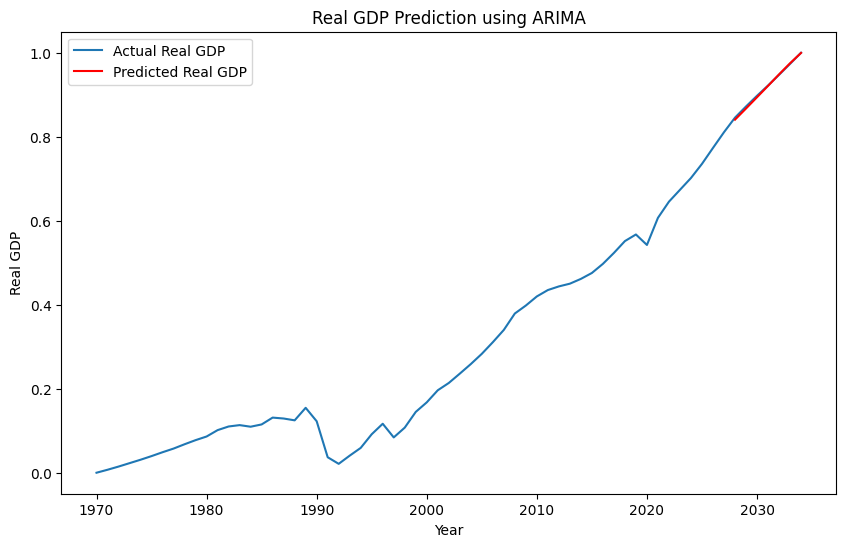


Forecasted Real GDP for the next 10 years:
    Year  Forecasted Real GDP
65  2035             1.023464
66  2036             1.044571
67  2037             1.065227
68  2038             1.085399
69  2039             1.105282
70  2040             1.124573
71  2041             1.142697
72  2042             1.159863
73  2043             1.176359
74  2044             1.192268


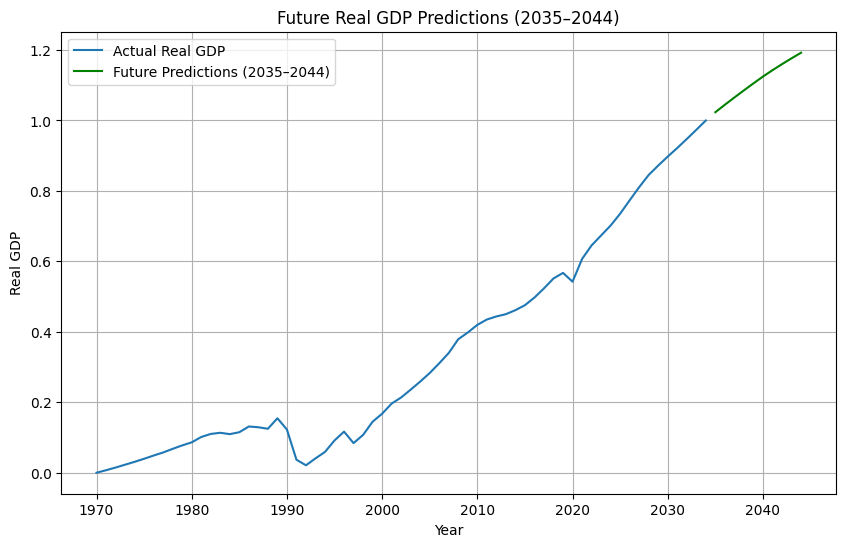

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

# Load the normalized data
file_path = '/content/Normalized_Albania_Information.csv'
data = pd.read_csv(file_path)

# Strip whitespace from column names (if any)
data.columns = data.columns.str.strip()

# Ensure 'Year' is treated as numeric for calculations
data['Year'] = pd.to_numeric(data['Year'])

# Extract the Real GDP data
real_gdp = data['Real GDP']

# Split data into train and test sets (e.g., last 10% for testing)
train_size = int(len(real_gdp) * 0.9)  # 90% for training
train_data = real_gdp[:train_size]
test_data = real_gdp[train_size:]

# Define a function to evaluate different ARIMA parameters
def find_best_arima(train_data, test_data, p_values, d_values, q_values):
    best_mse = float('inf')
    best_params = None
    best_model = None
    best_predictions = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # Fit ARIMA model
                    model = ARIMA(train_data, order=(p, d, q))
                    model_fit = model.fit()

                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test_data))

                    # Calculate MSE
                    mse = mean_squared_error(test_data, predictions)

                    # Update if the current model has a lower MSE
                    if mse < best_mse:
                        best_mse = mse
                        best_params = (p, d, q)
                        best_model = model_fit
                        best_predictions = predictions
                except Exception as e:
                    continue

    return best_model, best_params, best_predictions, best_mse

# Define possible values for p, d, and q
p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

# Find the best ARIMA model
best_model, best_params, best_predictions, best_mse = find_best_arima(train_data, test_data, p_values, d_values, q_values)

# Print the best parameters and MSE
print(f"Best ARIMA parameters: (p={best_params[0]}, d={best_params[1]}, q={best_params[2]})")
print(f"Best MSE: {best_mse}")

# Calculate RMSE
rmse = np.sqrt(best_mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate accuracy metrics
accuracy = 100 - (np.abs((test_data.values - best_predictions) / test_data.values) * 100)
accuracy_mean = np.mean(accuracy)

# Binary classification metrics
threshold = train_data.mean()  # Example threshold for economic growth
actual_binary = (test_data.values > threshold).astype(int)
predicted_binary = (best_predictions > threshold).astype(int)

precision = precision_score(actual_binary, predicted_binary, zero_division=0)
recall = recall_score(actual_binary, predicted_binary, zero_division=0)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Mean Accuracy: {accuracy_mean:.2f}%")

# Create a DataFrame to display the predicted and real GDP
results_df = pd.DataFrame({
    'Year': data['Year'][train_size:].values,
    'Real GDP': test_data.values,
    'Predicted GDP': best_predictions,
    'Accuracy (%)': accuracy
})
print("\nPredicted and Real GDP values with Accuracy:")
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], real_gdp, label='Actual Real GDP')
plt.plot(data['Year'][train_size:], best_predictions, label='Predicted Real GDP', color='red')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.title('Real GDP Prediction using ARIMA')
plt.legend()
plt.show()

# Re-train the ARIMA model on all data up to 2034
final_model = ARIMA(real_gdp, order=best_params).fit()

# Forecast the next 10 years (2035–2044)
future_steps = 10
future_years = np.arange(data['Year'].iloc[-1] + 1, data['Year'].iloc[-1] + 1 + future_steps)
future_predictions = final_model.forecast(steps=future_steps)

# Create a DataFrame for future predictions
future_forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted Real GDP': future_predictions
})

print("\nForecasted Real GDP for the next 10 years:")
print(future_forecast_df)

# Visualize the updated forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], real_gdp, label='Actual Real GDP')
plt.plot(future_forecast_df['Year'], future_forecast_df['Forecasted Real GDP'], label='Future Predictions (2035–2044)', color='green')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.title('Future Real GDP Predictions (2035–2044)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load the normalized data
file_path = '/content/Normalized_Albania_Information.csv'
data = pd.read_csv(file_path)

# Ensure column names and data types are correct
data.columns = data.columns.str.strip()
data['Year'] = pd.to_numeric(data['Year'])

# Extract Real GDP
real_gdp = data['Real GDP']

# Split data into training and testing sets
train_size = int(len(real_gdp) * 0.9)
train_data = real_gdp[:train_size]
test_data = real_gdp[train_size:]

# Fit ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))  # Example order, adjust as needed
model_fit = model.fit()

# Forecast GDP for 2028–2034
predicted_gdp_2028_2034 = model_fit.forecast(steps=len(test_data)).tolist()

# Calculate Predicted GDP Growth Rates for 2029–2034 based on predicted GDP
def calculate_growth_rate(gdp_values):
    return [((gdp_values[i] - gdp_values[i - 1]) / gdp_values[i - 1]) * 100 for i in range(1, len(gdp_values))]

predicted_growth_rate_2029_2034 = calculate_growth_rate(predicted_gdp_2028_2034)

# Extract Real GDP values for 2029–2034 from the data table
growth_data = data.loc[(data['Year'] >= 2029) & (data['Year'] <= 2034)].reset_index(drop=True)
years_2029_2034 = growth_data['Year'].tolist()
real_gdp_2029_2034 = growth_data['Real GDP'].tolist()

# Calculate Real GDP Growth Rates for 2029–2034 from the table based on the formula
real_growth_rate_2029_2034 = calculate_growth_rate(real_gdp_2029_2034)

# Ensure alignment of arrays
min_length = min(len(years_2029_2034), len(predicted_growth_rate_2029_2034), len(real_growth_rate_2029_2034))
years_2029_2034 = years_2029_2034[:min_length]
predicted_growth_rate_2029_2034 = predicted_growth_rate_2029_2034[:min_length]
real_growth_rate_2029_2034 = real_growth_rate_2029_2034[:min_length]

# Print results
print("Predicted GDP for 2028–2034:")
for i, year in enumerate(range(2028, 2035)):
    print(f"Year {year}: {predicted_gdp_2028_2034[i]:.2f}")

print("\nCalculated GDP Growth Rates for 2029–2034 (from predicted GDP):")
for i, year in enumerate(years_2029_2034):
    print(f"Year {year}: {predicted_growth_rate_2029_2034[i]:.2f}%")

print("\nReal GDP Growth Rates from the Table for 2029–2034:")
for i, year in enumerate(years_2029_2034):
    print(f"Year {year}: {real_growth_rate_2029_2034[i]:.2f}%")


Predicted GDP for 2028–2034:
Year 2028: 0.84
Year 2029: 0.87
Year 2030: 0.89
Year 2031: 0.92
Year 2032: 0.94
Year 2033: 0.97
Year 2034: 0.99

Calculated GDP Growth Rates for 2029–2034 (from predicted GDP):
Year 2029: 3.24%
Year 2030: 3.05%
Year 2031: 2.87%
Year 2032: 2.71%
Year 2033: 2.57%

Real GDP Growth Rates from the Table for 2029–2034:
Year 2029: 2.92%
Year 2030: 2.72%
Year 2031: 2.76%
Year 2032: 2.75%
Year 2033: 2.73%


In [6]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Year': years_2029_2034,
    'Predicted Growth Rate (%)': predicted_growth_rate_2029_2034,
    'Real Growth Rate (%)': real_growth_rate_2029_2034,
})

# Calculate the difference between predicted and real growth rates
comparison_df['Difference (%)'] = comparison_df['Predicted Growth Rate (%)'] - comparison_df['Real Growth Rate (%)']

# Print the comparison table
print("Comparison of Predicted and Real GDP Growth Rates for 2029–2034:")
print(comparison_df)

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(np.abs(comparison_df['Difference (%)']))
print(f"\nMean Absolute Error (MAE) of the predicted growth rates: {mae:.2f}%")


Comparison of Predicted and Real GDP Growth Rates for 2029–2034:
   Year  Predicted Growth Rate (%)  Real Growth Rate (%)  Difference (%)
0  2029                   3.239506              2.922886        0.316620
1  2030                   3.048375              2.719033        0.329342
2  2031                   2.873841              2.764706        0.109135
3  2032                   2.713896              2.747567       -0.033671
4  2033                   2.566845              2.729805       -0.162961

Mean Absolute Error (MAE) of the predicted growth rates: 0.19%


# ARIMA + RF

---



Best ARIMA parameters: (p=5, d=1, q=1)
Best MSE: 9.049181470151446e-06
Combined Model RMSE: 0.00
Mean Absolute Error (MAE): 0.00
Symmetric Mean Absolute Percentage Error (SMAPE): 0.03%
Root Mean Squared Error (RMSE): 0.00
R² (Coefficient of Determination): 1.00

Predicted and Real GDP values with Accuracy:
    Year  Real GDP  Predicted GDP  Accuracy (%)
58  2028  0.845445       0.840625     99.985767
59  2029  0.872017       0.867145     99.945740
60  2030  0.897505       0.894008     99.973925
61  2031  0.921909       0.921076     99.974311
62  2032  0.947397       0.948428     99.982976
63  2033  0.973427       0.974908     99.962008
64  2034  1.000000       0.999552     99.932659


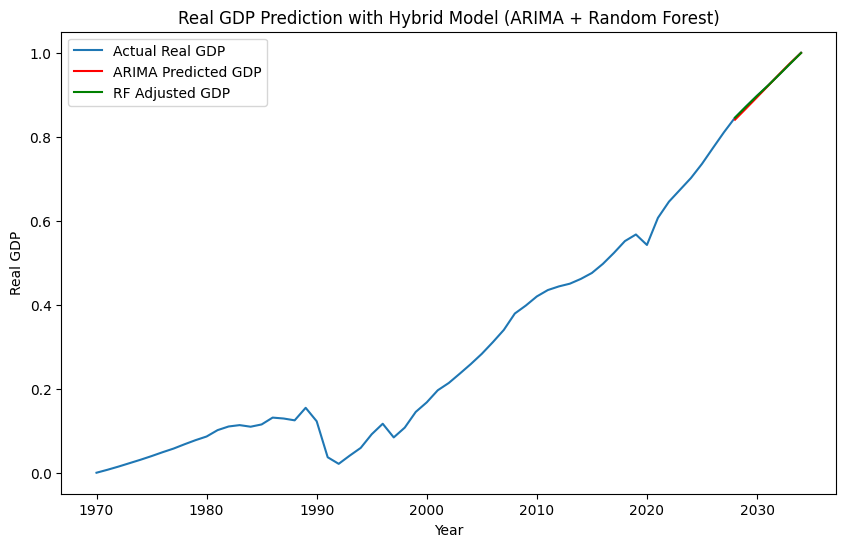

Combined Model Mean Accuracy: 99.97%
Combined Model Accuracy: 58    99.985767
59    99.945740
60    99.973925
61    99.974311
62    99.982976
63    99.962008
64    99.932659
Name: predicted_mean, dtype: float64
Combined Model Precision: 1.0
Combined Model Recall: 1.0

Forecasted Real GDP for 2035-2044 (Hybrid Model):
    Year  Forecasted Real GDP
65  2035             1.026313
66  2036             1.048068
67  2037             1.069729
68  2038             1.090098
69  2039             1.109681
70  2040             1.127837
71  2041             1.143293
72  2042             1.158994
73  2043             1.175247
74  2044             1.192043


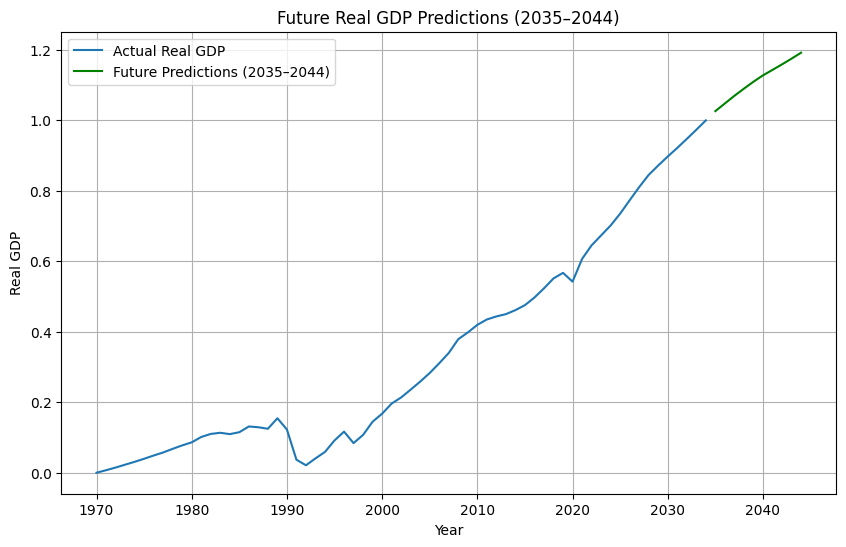

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, precision_score, recall_score, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Load the normalized data
file_path = '/content/Normalized_Albania_Information.csv'
data = pd.read_csv(file_path)

# Strip whitespace from column names (if any)
data.columns = data.columns.str.strip()

# Ensure 'Year' is treated as numeric for calculations
data['Year'] = pd.to_numeric(data['Year'])

# Extract the Real GDP data
real_gdp = data['Real GDP']

# Remove 'Year' and 'Real GDP' columns (target) for training
features = data.drop(columns=['Real GDP', 'Year'])

# Split data into train and test sets (90% for training, 10% for testing)
train_size = int(len(real_gdp) * 0.9)
X_train = features[:train_size]
y_train = real_gdp[:train_size]
X_test = features[train_size:]
y_test = real_gdp[train_size:]

# Fit the ARIMA model on training data
def find_best_arima(train_data, test_data, p_values, d_values, q_values):
    best_mse = float('inf')
    best_params = None
    best_model = None
    best_predictions = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # Fit ARIMA model
                    model = ARIMA(train_data, order=(p, d, q))
                    model_fit = model.fit()

                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test_data))

                    # Calculate MSE
                    mse = mean_squared_error(test_data, predictions)

                    # Update if the current model has a lower MSE
                    if mse < best_mse:
                        best_mse = mse
                        best_params = (p, d, q)
                        best_model = model_fit
                        best_predictions = predictions
                except Exception as e:
                    continue

    return best_model, best_params, best_predictions, best_mse

# Define possible values for p, d, and q
p_values = range(0, 6)  # Experiment with different AR terms
d_values = range(0, 2)  # Experiment with differencing
q_values = range(0, 6)  # Experiment with different MA terms

# Find the best ARIMA model
best_model, best_params, best_predictions, best_mse = find_best_arima(y_train, y_test, p_values, d_values, q_values)

# Print the best ARIMA parameters and MSE
print(f"Best ARIMA parameters: (p={best_params[0]}, d={best_params[1]}, q={best_params[2]})")
print(f"Best MSE: {best_mse}")

# # Calculate RMSE for ARIMA
# rmse = np.sqrt(best_mse)
# print(f"ARIMA RMSE: {rmse:.2f}")

# Step 1: Fit Random Forest model to predict residuals
arima_predictions = best_predictions
residuals = y_test - arima_predictions

# Use the test set features (X_test) for training the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    criterion='squared_error'
)

rf_model.fit(X_test, residuals)


# Step 2: Predict residuals using Random Forest for the test set
rf_predictions = rf_model.predict(X_test)

# Step 3: Combine ARIMA predictions with Random Forest predictions
combined_predictions = arima_predictions + rf_predictions

# Calculate the new MSE for the combined model
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
print(f"Combined Model RMSE: {combined_rmse:.2f}")

# Calculate Accuracy, Precision, Recall for Combined Model (for classification)
# Here, we assume classification based on a threshold of 5% deviation in prediction.
threshold = 0.05  # 5% threshold
predictions_class = np.abs((y_test.values - combined_predictions) / y_test.values) <= threshold

# Calculate classification metrics
accuracy = accuracy_score(np.ones_like(predictions_class), predictions_class)
precision = precision_score(np.ones_like(predictions_class), predictions_class)
recall = recall_score(np.ones_like(predictions_class), predictions_class)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, combined_predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

smape_value = smape(y_test.values, combined_predictions)
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value:.2f}%")

# RMSE (already calculated)
print(f"Root Mean Squared Error (RMSE): {combined_rmse:.2f}")

# Calculate R² (Coefficient of Determination)
r2 = r2_score(y_test, combined_predictions)
print(f"R² (Coefficient of Determination): {r2:.2f}")

# Calculate Accuracy for each prediction (percentage deviation from actual)
accuracy = 100 - (np.abs((y_test.values - combined_predictions) / y_test.values) * 100)
results_df = pd.DataFrame({
    'Year': data['Year'][train_size:].values,
    'Real GDP': test_data.values,
    'Predicted GDP': best_predictions,
    'Accuracy (%)': accuracy
})
print("\nPredicted and Real GDP values with Accuracy:")
print(results_df)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], real_gdp, label='Actual Real GDP')
plt.plot(data['Year'][train_size:], arima_predictions, label='ARIMA Predicted GDP', color='red')
plt.plot(data['Year'][train_size:], combined_predictions, label='RF Adjusted GDP', color='green')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.title('Real GDP Prediction with Hybrid Model (ARIMA + Random Forest)')
plt.legend()
plt.show()

# # Calculate the mean accuracy
mean_accuracy = np.mean(accuracy)
print(f"Combined Model Mean Accuracy: {mean_accuracy:.2f}%")
print(f"Combined Model Accuracy: {accuracy}")
print(f"Combined Model Precision: {precision}")
print(f"Combined Model Recall: {recall}")

# Forecast for 2035-2044 using the full data (1970–2034)
final_model = ARIMA(real_gdp[:train_size+len(y_test)], order=best_params).fit()
future_steps = 10
future_years = np.arange(data['Year'].iloc[-1] + 1, data['Year'].iloc[-1] + 1 + future_steps)
arima_future_predictions = final_model.forecast(steps=future_steps)

# Predict residuals for future years using the Random Forest model
X_future = features[-future_steps:]
rf_future_residuals = rf_model.predict(X_future)

# Combine ARIMA and RF predictions for future years
combined_future_predictions = arima_future_predictions + rf_future_residuals

# Step 4: Create a DataFrame for future predictions
future_forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted Real GDP': combined_future_predictions
})

print("\nForecasted Real GDP for 2035-2044 (Hybrid Model):")
print(future_forecast_df)

# Visualize the forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], real_gdp, label='Actual Real GDP')
plt.plot(future_forecast_df['Year'], future_forecast_df['Forecasted Real GDP'], label='Future Predictions (2035–2044)', color='green')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.title('Future Real GDP Predictions (2035–2044)')
plt.legend()
plt.grid(True)
plt.show()


# GB + SVM

---



Testing Results:
Combined Model - RMSE: 0.15
Combined Model - MAE: 0.14
Combined Model - R²: -7.89
Combined Model - SMAPE: 16.40%
Combined Model - Accuracy: 85.01%
Combined Model - Precision: 1.00
Combined Model - Recall: 1.00

Combined Gradient Boosting and SVM Results for Testing (2028–2034):
   Year  Real GDP  Gradient Boosting Predicted GDP  SVM Predicted GDP  \
0  2028  0.845445                         0.810208           0.770492   
1  2029  0.872017                         0.799063           0.776426   
2  2030  0.897505                         0.792230           0.781187   
3  2031  0.921909                         0.780451           0.784215   
4  2032  0.947397                         0.771653           0.785557   
5  2033  0.973427                         0.763697           0.784697   
6  2034  1.000000                         0.758431           0.781543   

   Combined Predicted GDP  Accuracy (%)  
0                0.790350     93.483351  
1                0.787745     90.33

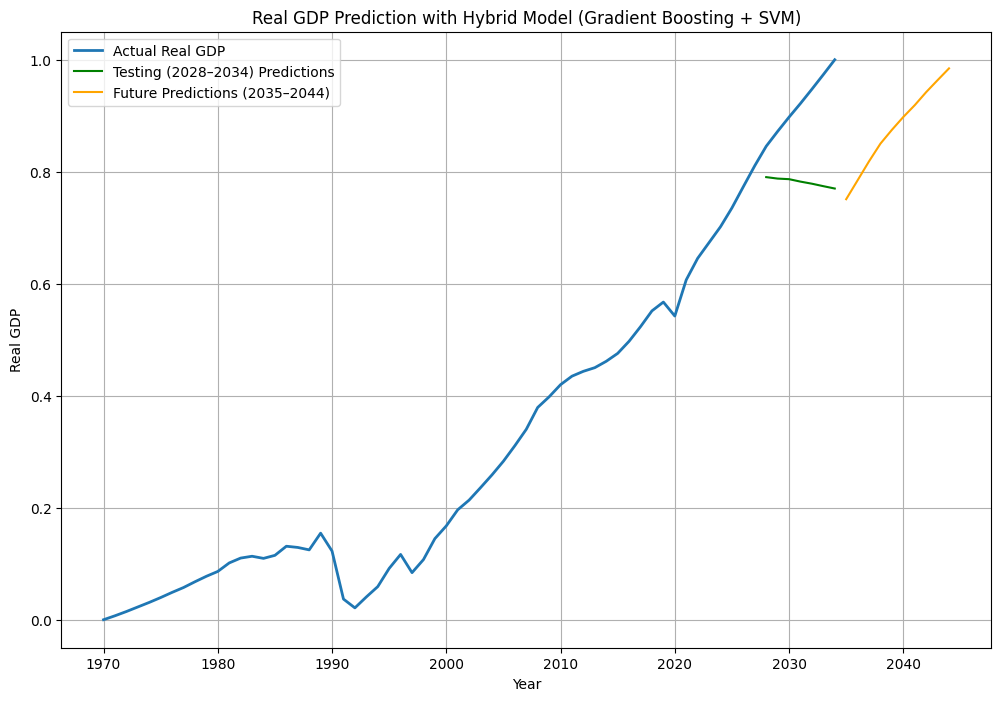

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, precision_score, recall_score, r2_score
from sklearn.impute import SimpleImputer

# Load the normalized data
file_path = '/content/Normalized_Albania_Information.csv'
data = pd.read_csv(file_path)

# Strip whitespace from column names (if any)
data.columns = data.columns.str.strip()

# Ensure 'Year' is treated as numeric for calculations
data['Year'] = pd.to_numeric(data['Year'])

# Extract the Real GDP data
real_gdp = data['Real GDP']

# Split data into train and test sets (90% fo r training, 10% testing)
train_size = int(len(real_gdp) * 0.9)  # 90% for training
train_data = real_gdp[:train_size]
test_data = real_gdp[train_size:]

# Prepare feature matrix for training (exclude 'Year' and 'Real GDP')
feature_columns = [col for col in data.columns if col not in ['Year', 'Real GDP']]  # Exclude 'Year' and 'Real GDP'
X_train = data[feature_columns].iloc[:train_size]
X_test = data[feature_columns].iloc[train_size:]

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=200,    # Increase the number of trees
    learning_rate=0.05,  # Decrease the learning rate
    max_depth=4,         # Set maximum depth of trees
    min_samples_split=10,
    subsample=0.8,       # Use 80% of samples for each tree
    random_state=42
)
gb_model.fit(X_train_imputed, train_data)

# Train Support Vector Machine model
svm_model = SVR(
    kernel='rbf',         # kernel function
    C=1000,
    epsilon=0.05,
    gamma='scale',
)

svm_model.fit(X_train_imputed, train_data)

# Make predictions using both models
gb_predictions = gb_model.predict(X_test_imputed)
svm_predictions = svm_model.predict(X_test_imputed)

# Combine predictions by averaging them
combined_predictions = 0.5*gb_predictions + 0.5*svm_predictions

 #Calculate metrics for the testing part
combined_mse = mean_squared_error(test_data, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test_data, combined_predictions)
combined_r2 = r2_score(test_data, combined_predictions)

# Function to calculate SMAPE
def calculate_smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))

combined_smape = calculate_smape(test_data.values, combined_predictions)

# Binary classification metrics for testing
threshold = train_data.mean()  # Example threshold for economic growth
actual_binary = (test_data.values > threshold).astype(int)
predicted_binary = (combined_predictions > threshold).astype(int)

precision = precision_score(actual_binary, predicted_binary, zero_division=0)
recall = recall_score(actual_binary, predicted_binary, zero_division=0)

print(f"Testing Results:")
print(f"Combined Model - RMSE: {combined_rmse:.2f}")
print(f"Combined Model - MAE: {combined_mae:.2f}")
print(f"Combined Model - R²: {combined_r2:.2f}")
print(f"Combined Model - SMAPE: {combined_smape:.2f}%")
print(f"Combined Model - Accuracy: {combined_accuracy_mean:.2f}%")
print(f"Combined Model - Precision: {precision:.2f}")
print(f"Combined Model - Recall: {recall:.2f}")



# Retrain on the entire dataset (1970–2034)
X_full = data[feature_columns].iloc[:train_size + len(test_data)]
y_full = real_gdp.iloc[:train_size + len(test_data)]

X_full_imputed = imputer.fit_transform(X_full)

gb_model.fit(X_full_imputed, y_full)
svm_model.fit(X_full_imputed, y_full)

# Predict GDP for 2035–2044
future_steps = 10
future_years = np.arange(data['Year'].iloc[-1] + 1, data['Year'].iloc[-1] + 1 + future_steps)
X_future = data[feature_columns].iloc[-future_steps:]  # Features for future years

X_future_imputed = imputer.transform(X_future)

gb_future_predictions = gb_model.predict(X_future_imputed)
svm_future_predictions = svm_model.predict(X_future_imputed)
combined_future_predictions = 0.7 * gb_future_predictions + 0.3 * svm_future_predictions

#Create a DataFrame for testing and future predictions
combined_results_df = pd.DataFrame({
    'Year': data['Year'][train_size:].values,
    'Real GDP': test_data.values,
    'Gradient Boosting Predicted GDP': gb_predictions,
    'SVM Predicted GDP': svm_predictions,
    'Combined Predicted GDP': combined_predictions,
    'Accuracy (%)': combined_accuracy
})

future_forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted Real GDP': combined_future_predictions
})

# Print testing and future results
print("\nCombined Gradient Boosting and SVM Results for Testing (2028–2034):")
print(combined_results_df)

print("\nForecasted Real GDP for 2035–2044:")
print(future_forecast_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(data['Year'], real_gdp, label='Actual Real GDP', linewidth=2)
plt.plot(data['Year'][train_size:], combined_predictions, label='Testing (2028–2034) Predictions', color='green')
plt.plot(future_forecast_df['Year'], combined_future_predictions, label='Future Predictions (2035–2044)', color='orange')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.title('Real GDP Prediction with Hybrid Model (Gradient Boosting + SVM)')
plt.legend()
plt.grid(True)
plt.show()

# GRADIENT BOOSTING + NEURAL NETWORK

---




Testing Results:
Combined Model - RMSE: 0.15
Combined Model - MAE: 0.14
Combined Model - R²: -7.09
Combined Model - SMAPE: 16.49%
Combined Model - Mean Accuracy: 84.81%

Combined Gradient Boosting and Neural Network Results (Testing Period 2028–2034):
   Year  Real GDP  Gradient Boosting Predicted GDP  \
0  2028  0.845445                         0.701588   
1  2029  0.872017                         0.700934   
2  2030  0.897505                         0.700758   
3  2031  0.921909                         0.700758   
4  2032  0.947397                         0.700758   
5  2033  0.973427                         0.700758   
6  2034  1.000000                         0.692624   

   Neural Network Predicted GDP  Combined Predicted GDP  Accuracy (%)  
0                      0.834758                0.754856     89.285075  
1                      0.855179                0.762632     87.456044  
2                      0.878212                0.771740     85.987197  
3                      0.9

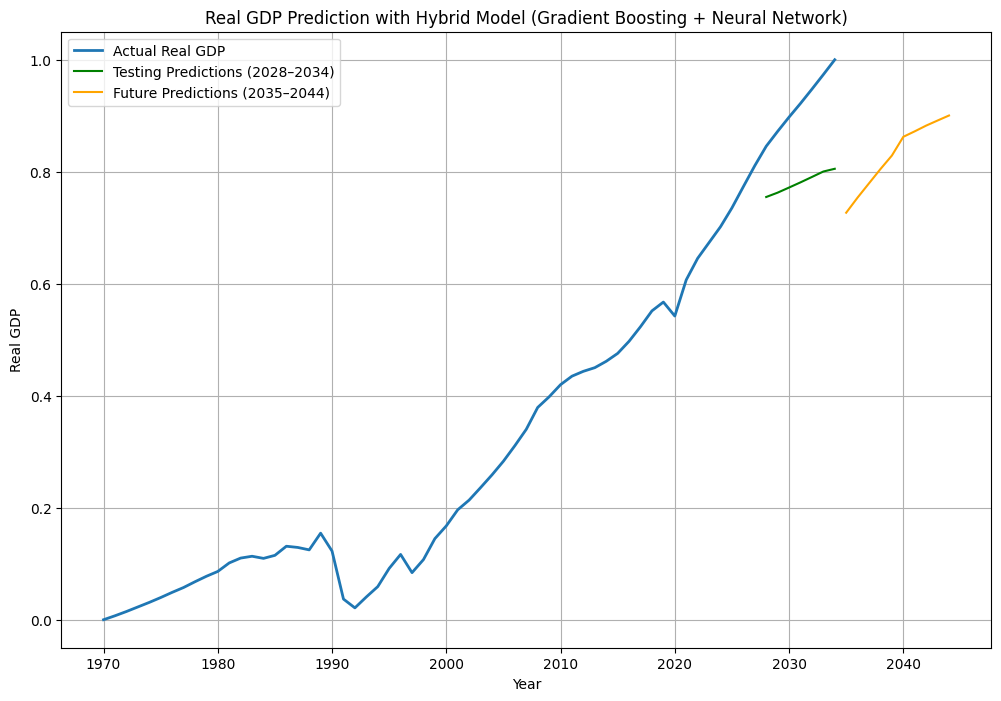

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Load the normalized data
file_path = '/content/Normalized_Albania_Information.csv'
data = pd.read_csv(file_path)

# Strip whitespace from column names (if any)
data.columns = data.columns.str.strip()

# Ensure 'Year' is treated as numeric for calculations
data['Year'] = pd.to_numeric(data['Year'])

# Extract the Real GDP data
real_gdp = data['Real GDP']

# Split data into train and test sets (e.g., last 5 years for testing)
train_size = int(len(real_gdp) * 0.9)  # 90% for training
train_data = real_gdp[:train_size]
test_data = real_gdp[train_size:]

#  Prepare feature matrix (all features except Year and Real GDP)
X_train = data.drop(columns=['Year', 'Real GDP']).iloc[:train_size]
X_test = data.drop(columns=['Year', 'Real GDP']).iloc[train_size:]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the feature matrix (train and test)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=300,         # More trees
    learning_rate=0.01,       # Lower learning rate
    max_depth=5,              # Moderate tree depth
    subsample=0.9,            # Use 90% of samples for each tree
    min_samples_split=10,     # Larger split size
    min_samples_leaf=5,       # Larger leaf size
    random_state=42
)

gb_model.fit(X_train_imputed, train_data)

# Train Neural Network model (MLP with Backpropagation)

nn_model = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  # Deeper network
    activation='relu',                 # Change activation to ReLU
    solver='adam',
    alpha=0.001,                       # Lower regularization
    learning_rate_init=0.001,          # Explicit learning rate
    max_iter=2000,                     # More iterations
    early_stopping=True,
    random_state=42
)
nn_model.fit(X_train_imputed, train_data)

# Make predictions using both models
gb_predictions = gb_model.predict(X_test_imputed)
nn_predictions = nn_model.predict(X_test_imputed)

# Combine predictions by averaging them

combined_predictions = 0.6 * gb_predictions + 0.4 * nn_predictions
#  Calculate metrics for the combined model
combined_mse = mean_squared_error(test_data, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test_data, combined_predictions)
combined_r2 = r2_score(test_data, combined_predictions)

# Function to calculate SMAPE
def calculate_smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))

combined_smape = calculate_smape(test_data.values, combined_predictions)

# Calculate mean accuracy for predictions
combined_accuracy = 100 - (np.abs((test_data.values - combined_predictions) / test_data.values) * 100)
combined_accuracy_mean = np.mean(combined_accuracy)

# Print the results
print("\nTesting Results:")
print(f"Combined Model - RMSE: {combined_rmse:.2f}")
print(f"Combined Model - MAE: {combined_mae:.2f}")
print(f"Combined Model - R²: {combined_r2:.2f}")
print(f"Combined Model - SMAPE: {combined_smape:.2f}%")
print(f"Combined Model - Mean Accuracy: {combined_accuracy_mean:.2f}%")

# Retrain on the entire dataset (1970–2034)
X_full = data.drop(columns=['Year', 'Real GDP'])
y_full = real_gdp
X_full_imputed = imputer.fit_transform(X_full)

gb_model.fit(X_full_imputed, y_full)
nn_model.fit(X_full_imputed, y_full)

# Predict GDP for 2035–2044
future_steps = 10
future_years = np.arange(data['Year'].iloc[-1] + 1, data['Year'].iloc[-1] + 1 + future_steps)
X_future = data.drop(columns=['Year', 'Real GDP']).iloc[-future_steps:]  # Features for future years
X_future_imputed = imputer.transform(X_future)

gb_future_predictions = gb_model.predict(X_future_imputed)
nn_future_predictions = nn_model.predict(X_future_imputed)
combined_future_predictions = (gb_future_predictions + nn_future_predictions) / 2

# Create DataFrames for testing and future predictions
combined_results_df = pd.DataFrame({
    'Year': data['Year'][train_size:].values,
    'Real GDP': test_data.values,
    'Gradient Boosting Predicted GDP': gb_predictions,
    'Neural Network Predicted GDP': nn_predictions,
    'Combined Predicted GDP': combined_predictions,
    'Accuracy (%)': combined_accuracy
})

future_forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted Real GDP': combined_future_predictions
})

# Print combined results and metrics summary
print("\nCombined Gradient Boosting and Neural Network Results (Testing Period 2028–2034):")
print(combined_results_df)

print("\nForecasted Real GDP for 2035–2044:")
print(future_forecast_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(data['Year'], real_gdp, label='Actual Real GDP', linewidth=2)
plt.plot(data['Year'][train_size:], combined_predictions, label='Testing Predictions (2028–2034)', color='green')
plt.plot(future_forecast_df['Year'], combined_future_predictions, label='Future Predictions (2035–2044)', color='orange')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.title('Real GDP Prediction with Hybrid Model (Gradient Boosting + Neural Network)')
plt.legend()
plt.grid(True)
plt.show()
